In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# ========================== 1. 定义 VAE 网络 ========================== #
class VAE(nn.Module):
    def __init__(self, input_dim=10, latent_dim=2, output_dim=10):
        """
        变分自编码器 (VAE) 结构
        :param input_dim: 输入数据的维度，例如机器人状态的特征数
        :param inter_dim: 中间隐藏层的神经元数量
        :param latent_dim: 潜在空间的维度 (通常小于 input_dim)
        """
        super(VAE, self).__init__()

        # 编码器 (encoder)，用于提取特征并生成均值 (mu) 和方差 (logvar)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),  # 输入层 -> 隐藏层
            nn.LayerNorm(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, latent_dim * 2),  # 隐藏层 -> 输出层 (均值和方差)
        )

        # 解码器 (decoder)，用于从潜在空间重构输入
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),  # 潜在空间 -> 隐藏层
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim),  # 隐藏层 -> 重建输入
            nn.Sigmoid(),  # 使用 Sigmoid 限制输出范围在 [0,1]
        )

    def reparameterize(self, mu, logvar):
        """
        重新参数化 (Reparameterization Trick)，用于从高斯分布中采样
        :param mu: 均值
        :param logvar: 对数方差
        :return: 采样后的潜在变量 z
        """
        epsilon = torch.randn_like(mu)  # 生成与 mu 形状相同的标准正态分布随机变量
        return mu + epsilon * torch.sqrt(torch.exp(logvar))  # 计算 z = μ + ε * σ

    def forward(self, x):
        """
        前向传播
        :param x: 输入数据
        :return: 重构的 x, 均值 mu, 对数方差 logvar
        """
        h = self.encoder(x)  # 通过编码器提取特征
        mu, logvar = h.chunk(2, dim=1)  # 将输出拆分为均值和对数方差
        z = self.reparameterize(mu, logvar)  # 重新参数化采样
        recon_x = self.decoder(z)  # 通过解码器重建输入
        return recon_x, mu, logvar




In [3]:
# ========================== 2. 自定义数据集 ========================== #
class RLObservationDataset(Dataset):
    """
    强化学习环境观测数据集
    用于存储从 RL 环境收集的观测值
    """

    def __init__(self, file_path):
        import pandas as pd
        self.data = pd.read_csv(file_path).values  # 读取 CSV 并转换为 NumPy 数组
        # self.data = np.load(file_path)  # 载入 NumPy 数据文件
        self.data = self.normalize_data(self.data)  # 归一化数据
        self.data = torch.tensor(self.data, dtype=torch.float32)  # 转换为 PyTorch Tensor

    def normalize_data(self, data):
        """
        归一化数据到 [0,1] 之间，避免 BCE 损失函数报错。
        :param data: numpy.ndarray, 原始数据
        :return: numpy.ndarray, 归一化后的数据
        """
        min_val = data.min(axis=0)  # 计算每列的最小值
        max_val = data.max(axis=0)  # 计算每列的最大值

        # **避免除以 0 的情况**
        range_val = max_val - min_val
        range_val[range_val == 0] = 1  # 如果最大值和最小值相同，则防止除以 0

        # return (data - min_val) / range_val  # 归一化到 [0,1]
        return 1 / (1 + np.exp(-data))

    def __len__(self):
        return len(self.data)  # 返回数据集的大小

    def __getitem__(self, idx):
        return self.data[idx], 0  # 返回 (数据, 标签)，标签在 VAE 里不用




In [24]:
# ========================== 3. 训练参数 ========================== #
epochs = 50  # 训练轮数
batch_size = 1024  # 每个批次的样本数量
input_dim = 6  # 输入数据的维度 (你的环境观测值的大小)
output_dim = 3
latent_dim = 3  # 潜在空间的维度

# 加载自定义数据集
from torch.utils.data import random_split

# 设定训练集和测试集比例
train_ratio = 0.8  # 80% 作为训练集，20% 作为测试集
dataset = RLObservationDataset("log.csv")

# 计算训练集和测试集的大小
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# 随机划分数据
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"训练集大小: {len(train_dataset)}, 测试集大小: {len(test_dataset)}")

# 设备选择 (GPU 优先)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 初始化模型和优化器
model = VAE(input_dim, latent_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 损失函数
kl_loss = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
recon_loss = lambda recon_x, x: F.binary_cross_entropy(recon_x, x, reduction='sum')

# 记录损失值
train_losses = []


训练集大小: 191999, 测试集大小: 48000


In [25]:
# ========================== 4. 训练 VAE ========================== #
best_loss = float('inf')  # 记录最佳损失

for epoch in range(epochs):
    # print(f"Epoch {epoch}")
    model.train()
    train_loss = 0.

    for idx, (x, _) in enumerate(train_loader):
        batch = x.size(0)
        x = x.to(device)
        _x = x[:, np.r_[:3, 42:45]]
        real_x = x[:, -42:-39]#x[:, -42:]
        recon_x, mu, logvar = model(_x)

        # 计算损失：重构损失 + KL 散度
        recon = recon_loss(recon_x, real_x)
        kl = kl_loss(mu, logvar)
        loss = recon + kl

        train_loss += loss.item()
        loss = loss / batch  # 归一化损失

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f"Epoch {epoch} 训练损失 {loss:.3f} \t 重构损失 {recon / batch:.3f} \t KL {kl / batch:.3f} 在步骤 {idx}")

    epoch_loss = train_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # 记录并保存最优模型
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), "vae_model.pth")
        print(f"Epoch {epoch}: 发现更优模型，已保存。")



Epoch 0 训练损失 2.416 	 重构损失 2.078 	 KL 0.338 在步骤 0
Epoch 0 训练损失 2.061 	 重构损失 2.040 	 KL 0.020 在步骤 100
Epoch 0: 发现更优模型，已保存。
Epoch 1 训练损失 2.017 	 重构损失 2.016 	 KL 0.001 在步骤 0
Epoch 1 训练损失 2.000 	 重构损失 2.000 	 KL 0.000 在步骤 100
Epoch 1: 发现更优模型，已保存。
Epoch 2 训练损失 1.989 	 重构损失 1.989 	 KL 0.000 在步骤 0
Epoch 2 训练损失 1.983 	 重构损失 1.982 	 KL 0.000 在步骤 100
Epoch 2: 发现更优模型，已保存。
Epoch 3 训练损失 1.980 	 重构损失 1.979 	 KL 0.000 在步骤 0
Epoch 3 训练损失 1.977 	 重构损失 1.977 	 KL 0.000 在步骤 100
Epoch 3: 发现更优模型，已保存。
Epoch 4 训练损失 1.977 	 重构损失 1.976 	 KL 0.000 在步骤 0
Epoch 4 训练损失 1.975 	 重构损失 1.975 	 KL 0.000 在步骤 100
Epoch 4: 发现更优模型，已保存。
Epoch 5 训练损失 1.976 	 重构损失 1.976 	 KL 0.000 在步骤 0
Epoch 5 训练损失 1.975 	 重构损失 1.975 	 KL 0.000 在步骤 100
Epoch 5: 发现更优模型，已保存。
Epoch 6 训练损失 1.974 	 重构损失 1.974 	 KL 0.000 在步骤 0
Epoch 6 训练损失 1.974 	 重构损失 1.974 	 KL 0.000 在步骤 100
Epoch 6: 发现更优模型，已保存。
Epoch 7 训练损失 1.973 	 重构损失 1.973 	 KL 0.000 在步骤 0
Epoch 7 训练损失 1.972 	 重构损失 1.972 	 KL 0.000 在步骤 100
Epoch 7: 发现更优模型，已保存。
Epoch 8 训练损失 1.972 	 重构损失 1.972 

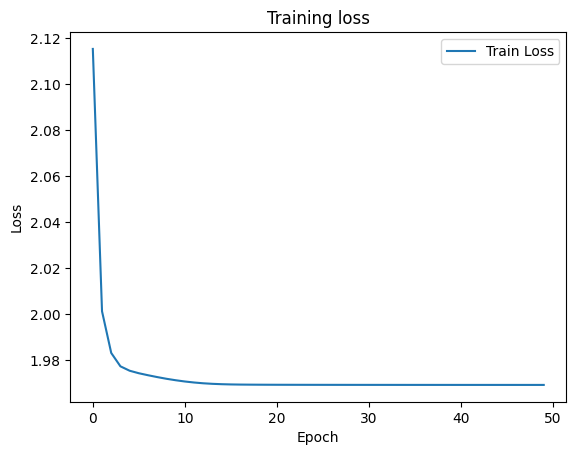

In [26]:
# ========================== 5. 可视化学习曲线 ========================== #
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


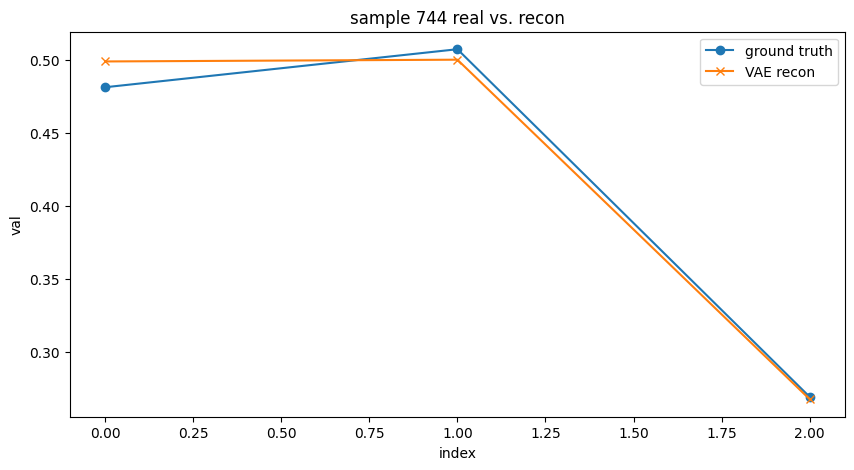

In [27]:
# ========================== 6. 生成潜在空间样本 ========================== #
model = VAE(input_dim, latent_dim, output_dim).to(device)
model.load_state_dict(torch.load("vae_model.pth", map_location=device))
# 设置为评估模式（禁用 dropout/batch norm 等）
model.eval()

import random
# 随机选择一个批次的数据
# data_iter = iter(test_loader)
# random_batch = next(data_iter)
random_batch = random.choice(list(test_loader))
x_test, _ = random_batch  # 取出输入数据
x_test = x_test.to(device)

# 只取部分特征进行重构
_x_test = x_test[:, np.r_[:3, 42:45]]
real_x_test = x_test[:, -42:-39]  # 真实值

# 进行推理
model.eval()
with torch.no_grad():
    recon_x_test, _, _ = model(_x_test)

# 转换为 NumPy 方便可视化
_x_test_np = _x_test.cpu().numpy()
real_x_test_np = real_x_test.cpu().numpy()
recon_x_test_np = recon_x_test.cpu().numpy()

# 打印部分测试结果
# print("原始输入 (部分特征):", _x_test_np[:5])  # 取前5个样本
# print("真实输出:", real_x_test_np[:5])
# print("重构输出:", recon_x_test_np[:5])

import matplotlib.pyplot as plt

index = random.randint(0, batch_size - 1)

plt.figure(figsize=(10, 5))
plt.plot(real_x_test_np[index], label="ground truth", marker='o')
plt.plot(recon_x_test_np[index], label="VAE recon", marker='x')
plt.legend()
plt.title(f"sample {index} real vs. recon")
plt.xlabel("index")
plt.ylabel("val")
plt.show()

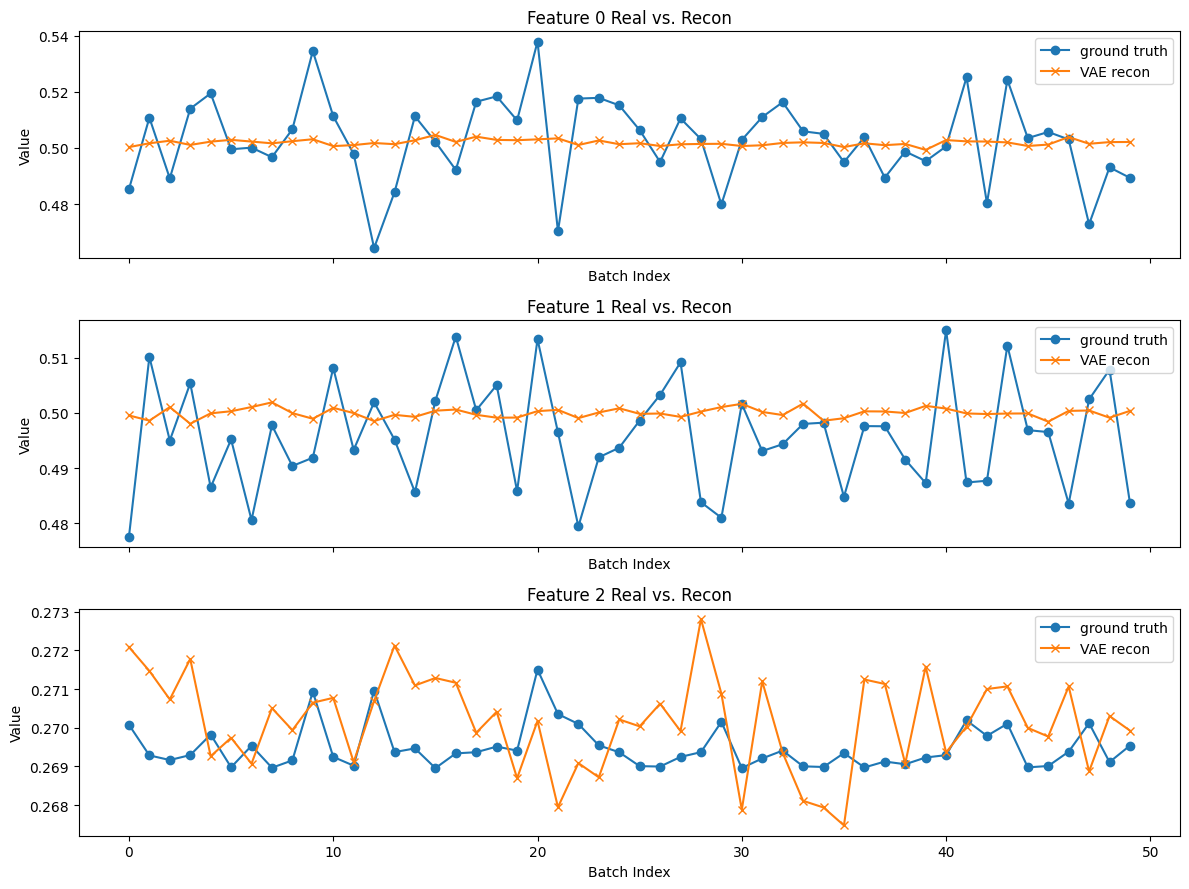

In [31]:
import matplotlib.pyplot as plt
import numpy as np

model = VAE(input_dim, latent_dim, output_dim).to(device)
model.load_state_dict(torch.load("vae_model.pth", map_location=device))
# 设置为评估模式（禁用 dropout/batch norm 等）
model.eval()

import random
# 随机选择一个批次的数据
random_batch = random.choice(list(test_loader))
x_test, _ = random_batch  # 取出输入数据
x_test = x_test.to(device)

# 只取部分特征进行重构
_x_test = x_test[:,  np.r_[:3, 42:45]]
real_x_test = x_test[:, -42:-39]#x_test[:, -42:]  # 真实值

# 进行推理
model.eval()
with torch.no_grad():
    recon_x_test, _, _ = model(_x_test)

# 转换为 NumPy 方便可视化
_x_test_np = _x_test.cpu().numpy()
real_x_test_np = real_x_test.cpu().numpy()
recon_x_test_np = recon_x_test.cpu().numpy()

# 假设 batch_size 和 feature_dim 已知
batch_size = real_x_test_np.shape[0]  # 批次大小
num_features = real_x_test_np.shape[1]  # 特征数量
num_features = 3

# 创建多个子图，每个子图表示一个元素的 real 和 recon 值
fig, axes = plt.subplots(nrows=num_features, figsize=(12, num_features * 3), sharex=True)

# 确保 axes 是一个可迭代的数组
if num_features == 1:
    axes = [axes]

# 遍历每个特征
for i in range(num_features):
    axes[i].plot(np.arange(50), real_x_test_np[:50, i], label="ground truth", marker='o')
    axes[i].plot(np.arange(50), recon_x_test_np[:50, i], label="VAE recon", marker='x')
    axes[i].set_title(f"Feature {i} Real vs. Recon")
    axes[i].set_xlabel("Batch Index")
    axes[i].set_ylabel("Value")
    axes[i].legend()

# 调整布局
plt.tight_layout()
plt.show()
